<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset

from transformers import BertForSequenceClassification, AutoTokenizer

In [2]:
df = pd.read_excel('data_problems_translated.xlsx').drop(columns=['Unnamed: 0']).dropna()
df.head()

,problem_text,topic
0,To prove that the sum of the numbers of the ex...,number_theory
1,( b) Will the statement of the previous challe...,number_theory
2,The quadratic three-member graph with the coef...,polynoms
3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,"Dima, who came from Vrunlandia, said that ther...",graphs


In [3]:
X = df['problem_text']
y = LabelEncoder().fit_transform(df['topic']) 

num_classes = df['topic'].nunique()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y}))

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
def get_model(model_name):
    return BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

In [ ]:
def get_tokenizer(model_name):
    tokenizer_base = AutoTokenizer.from_pretrained(model_name)

    batch_size = 256
    
    training_corpus = (dataset[i : i + batch_size]["text"] for i in range(0, len(dataset), batch_size))

    vocab_size = 5000
    tokenizer = tokenizer_base.train_new_from_iterator(training_corpus, vocab_size)

    return tokenizer

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [9]:
def freeze_backbone_function(model):
    model_freeze = copy.deepcopy(model)

    for name, param in model_freeze.named_parameters():
        if not 'classifier' in name:
            param.requires_grad = False

    return model_freeze

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [10]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [11]:
import copy
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

def train_transformer(model_name, train_dataset, test_dataset, n_epoch=10, freeze_backbone=True):
    model = get_model(model_name)
    tokenizer = get_tokenizer(model_name)

    if freeze_backbone:
        model = freeze_backbone_function(model)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True, max_length=50, add_special_tokens = True)
    
    train_dataset = train_dataset.map(preprocess_function, batched=True)
    test_dataset = test_dataset.map(preprocess_function, batched=True)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    
    training_args = TrainingArguments(
    output_dir="model/",
    num_train_epochs=n_epoch,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=2,
    weight_decay=0.01,
    learning_rate = 3e-4,
    logging_strategy = 'epoch',
    evaluation_strategy="epoch",
    save_strategy="no",
    )

    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics)

    trainer.train()

    return {'model_name': model_name, 'model':model, 'tokenizer': tokenizer}

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [12]:
rubert_tiny_transformer_model_name = "cointegrated/rubert-tiny2"
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model_name, train_dataset, test_dataset, freeze_backbone=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.675100,1.584660,0.454459
2,1.557800,1.551135,0.454459
3,1.530100,1.530467,0.454459
4,1.516900,1.515574,0.454459
5,1.498600,1.504665,0.455408
6,1.489800,1.496264,0.455408
7,1.482000,1.490448,0.455408
8,1.476000,1.486247,0.455408
9,1.472400,1.483880,0.455408
10,1.472900,1.483020,0.455408


In [13]:
rubert_tiny_transformer_model_name = "cointegrated/rubert-tiny2"
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model_name, train_dataset, test_dataset, freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.309000,1.109742,0.587287
2,0.998900,1.069812,0.608159
3,0.812900,1.071458,0.613852
4,0.659400,1.171630,0.562619
5,0.561200,1.292356,0.560721
6,0.478800,1.393608,0.525617
7,0.432500,1.470190,0.542694
8,0.378300,1.650444,0.533207
9,0.339600,1.684511,0.523719
10,0.301700,1.766213,0.516129


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

Скоры MathBert без заморозки во время обучения не поменялись, в связи с тем, что модели нужно гораздо больше итераций обучения, тк много параметров.  Скоры MathBert с заморозкой лучше скоров rubert с заморозкой.

In [14]:
mathbert_transformer_model_name = "tbs17/MathBert"
mathbert_finetuned_with_freezed_backbone = train_transformer(mathbert_transformer_model_name, train_dataset, test_dataset, n_epoch=50, freeze_backbone=True)

C:\Users\fluke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.609800,1.554007,0.454459
2,1.558200,1.526624,0.454459
3,1.523300,1.512656,0.454459
4,1.508200,1.460752,0.462998
5,1.488700,1.447517,0.455408
6,1.469600,1.417707,0.462049
7,1.452600,1.409881,0.469639
8,1.446900,1.388675,0.483871
9,1.430900,1.377811,0.484820
10,1.431500,1.394360,0.477230


In [15]:
mathbert_transformer_model_name = "tbs17/MathBert"
mathbert_full_finetuned = train_transformer(mathbert_transformer_model_name, train_dataset, test_dataset, n_epoch=50, freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.655600,1.616076,0.454459
2,1.643500,1.621516,0.454459
3,1.633000,1.634742,0.454459
4,1.644100,1.629431,0.454459
5,1.641900,1.644432,0.454459
6,1.643400,1.630376,0.454459
7,1.644300,1.612702,0.454459
8,1.639800,1.608824,0.454459
9,1.634900,1.622382,0.454459
10,1.638300,1.622196,0.454459


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [21]:
import matplotlib.pyplot as plt
import torch

def draw_first_layer_attention_maps(text, model_and_tokenizer):
    print("Название модели:",model_and_tokenizer['model_name'])
    tokenizer = model_and_tokenizer['tokenizer']
    model = model_and_tokenizer['model'].to('cpu')

    attention_head_ids = [i for i in range(model.config.num_attention_heads)]
    
    tokenized_text = tokenizer(text, truncation=True, padding=True, max_length=50, add_special_tokens=True)['input_ids']

    tokenized_text_tensor = torch.tensor(tokenized_text).unsqueeze(0).to('cpu')

    outputs = model(tokenized_text_tensor, output_attentions=True)
    
    attentions = outputs.attentions  # First layer attentions

    words = [tokenizer.convert_ids_to_tokens(int(token_id)) for token_id in tokenized_text]

    figure, axis = plt.subplots(3, 4)
    figure.set_figheight(15)
    figure.set_figwidth(20)    
    for i in range(3):
        for j in range(4):
            axis[i, j].matshow(attentions[0][0][i*4 + j].cpu().detach().numpy())
            axis[i, j].tick_params(axis='x', rotation=90)

            axis[i, j].set_xticks(range(len(words)))
            axis[i, j].set_yticks(range(len(words)))

            axis[i, j].set_xticklabels(words)
            axis[i, j].set_yticklabels(words)
    plt.show()   


### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

Прослеживается зависимость между токеном точки и токеном конца последовательности.

In [17]:
def make_model_staff_dict(model_name):
    model = get_model(model_name)
    tokenizer = get_tokenizer(model_name)

    return {'model_name': model_name, 'model': model, 'tokenizer': tokenizer}

In [18]:
models = {'finetuned': [rubert_tiny_finetuned_with_freezed_backbone, rubert_tiny_full_finetuned, mathbert_finetuned_with_freezed_backbone, mathbert_full_finetuned], \
           'pretrained': [make_model_staff_dict(rubert_tiny_transformer_model_name), make_model_staff_dict(mathbert_transformer_model_name)]}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Текст: To prove that the sum of the numbers of the exact square cannot be equal to 5.
Название модели: cointegrated/rubert-tiny2


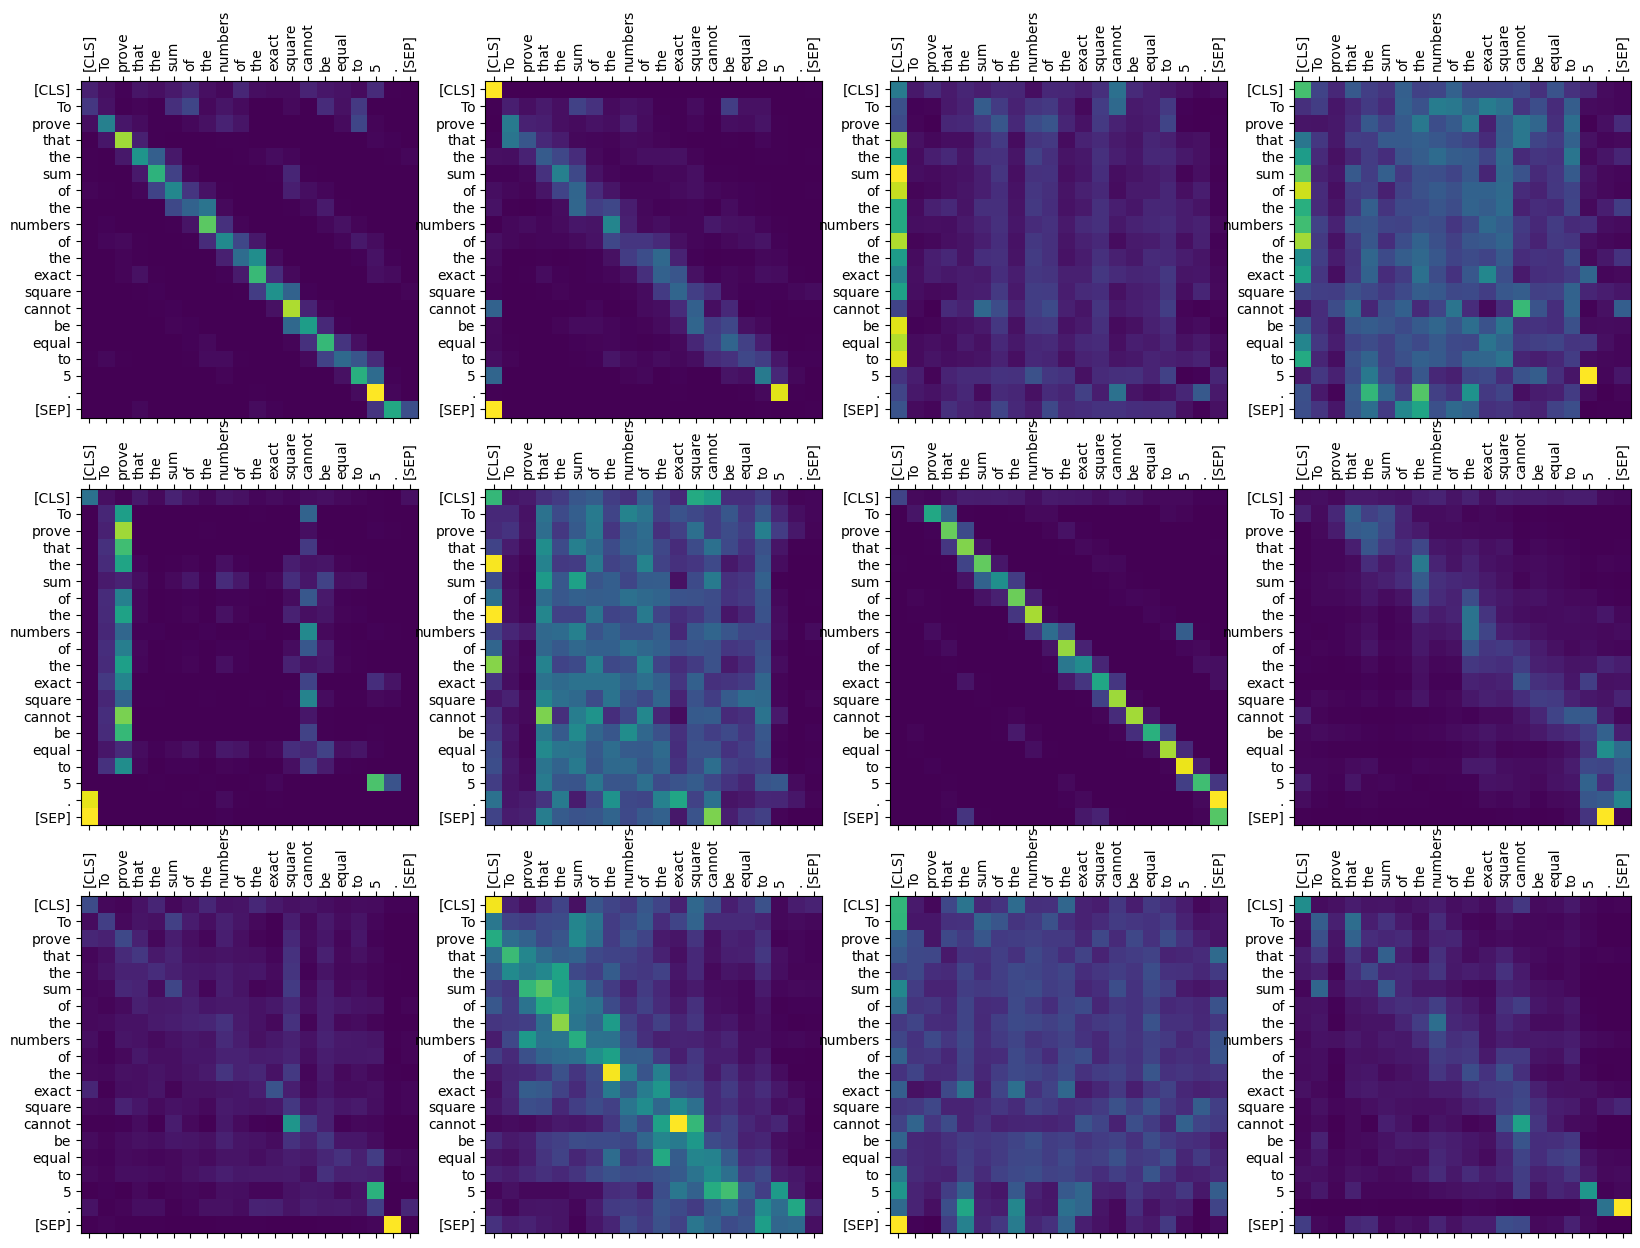

Название модели: tbs17/MathBert


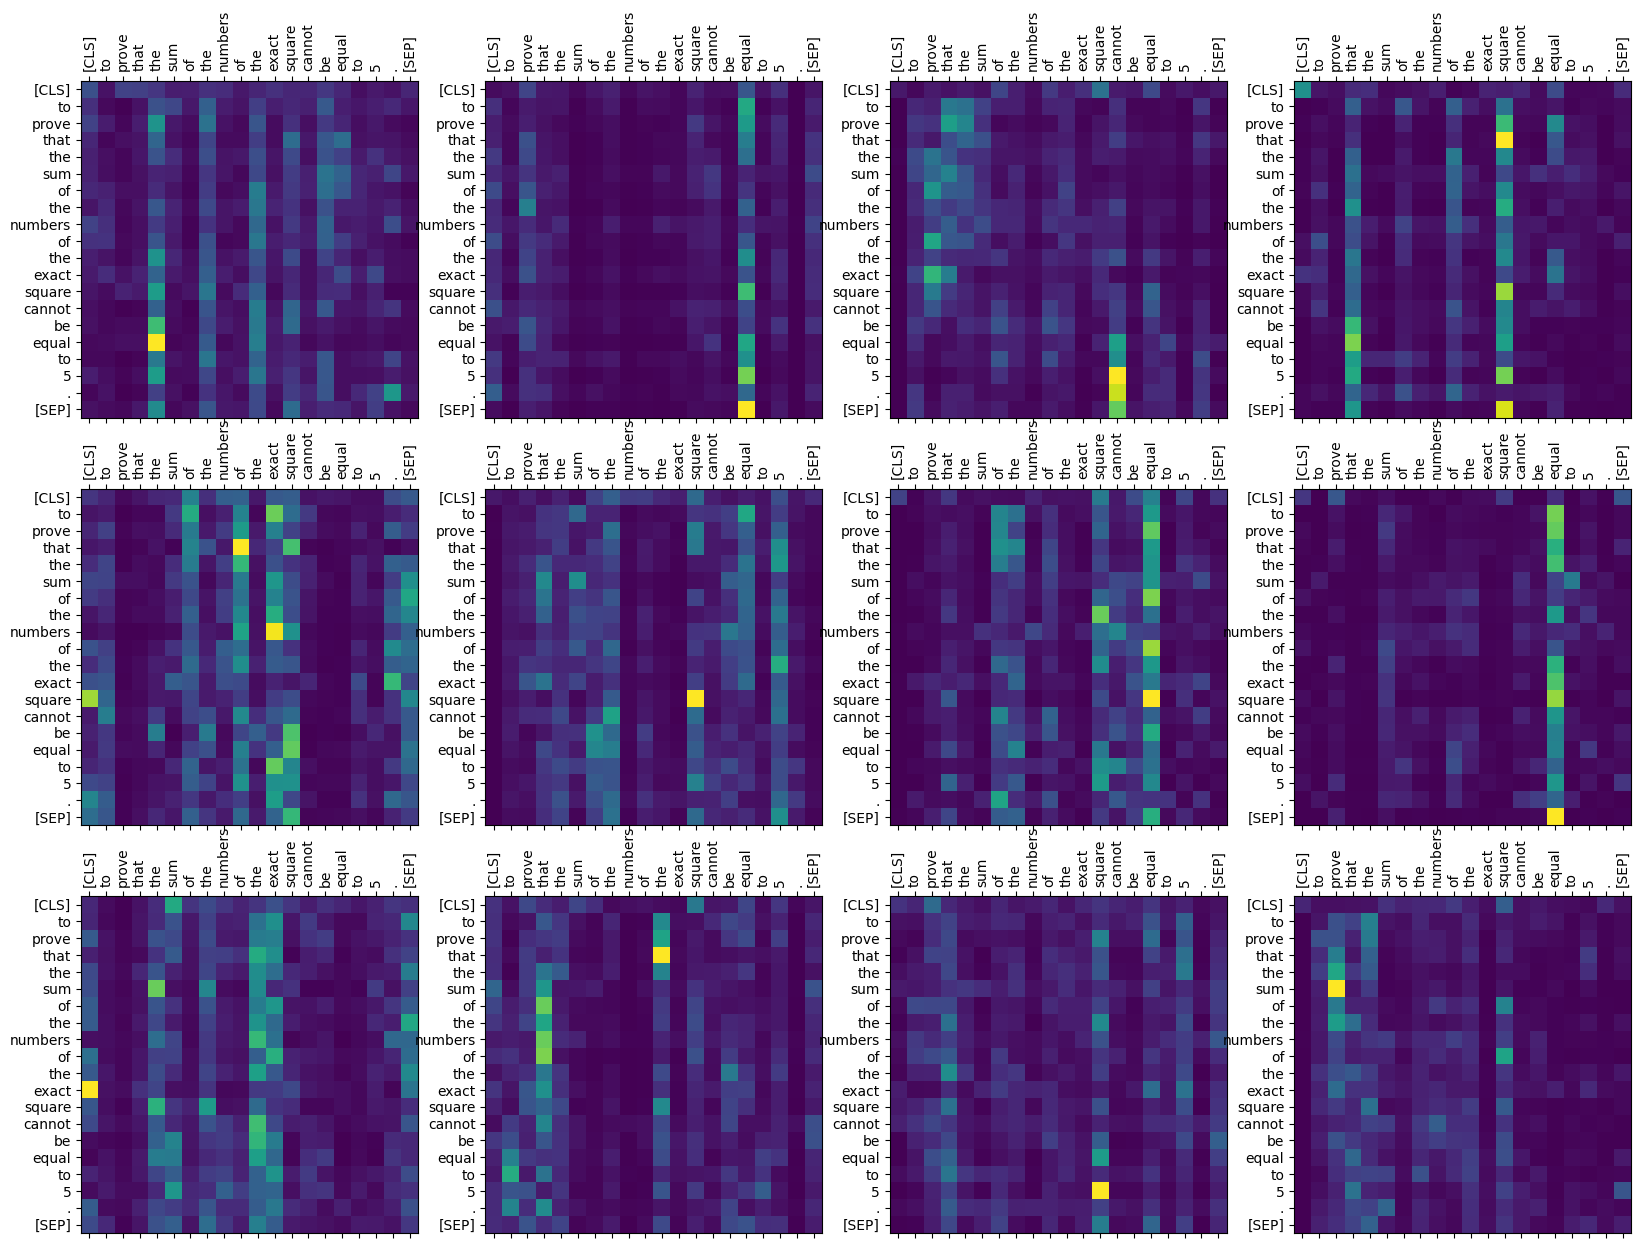

In [22]:
text = dataset[0]['text']
print("Текст:", text)
for model_stuff in models['pretrained']:
    draw_first_layer_attention_maps(text,  model_stuff)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Карты внимания изменились для моделей без заморозки. Это происходит из-за того, что дообученные модели адаптируются к специфическим данным или задачам, на которых они были дообучены. В результате модель может начать обращать большее внимание на определенные аспекты входных данных

Текст: To prove that the sum of the numbers of the exact square cannot be equal to 5.
Название модели: cointegrated/rubert-tiny2


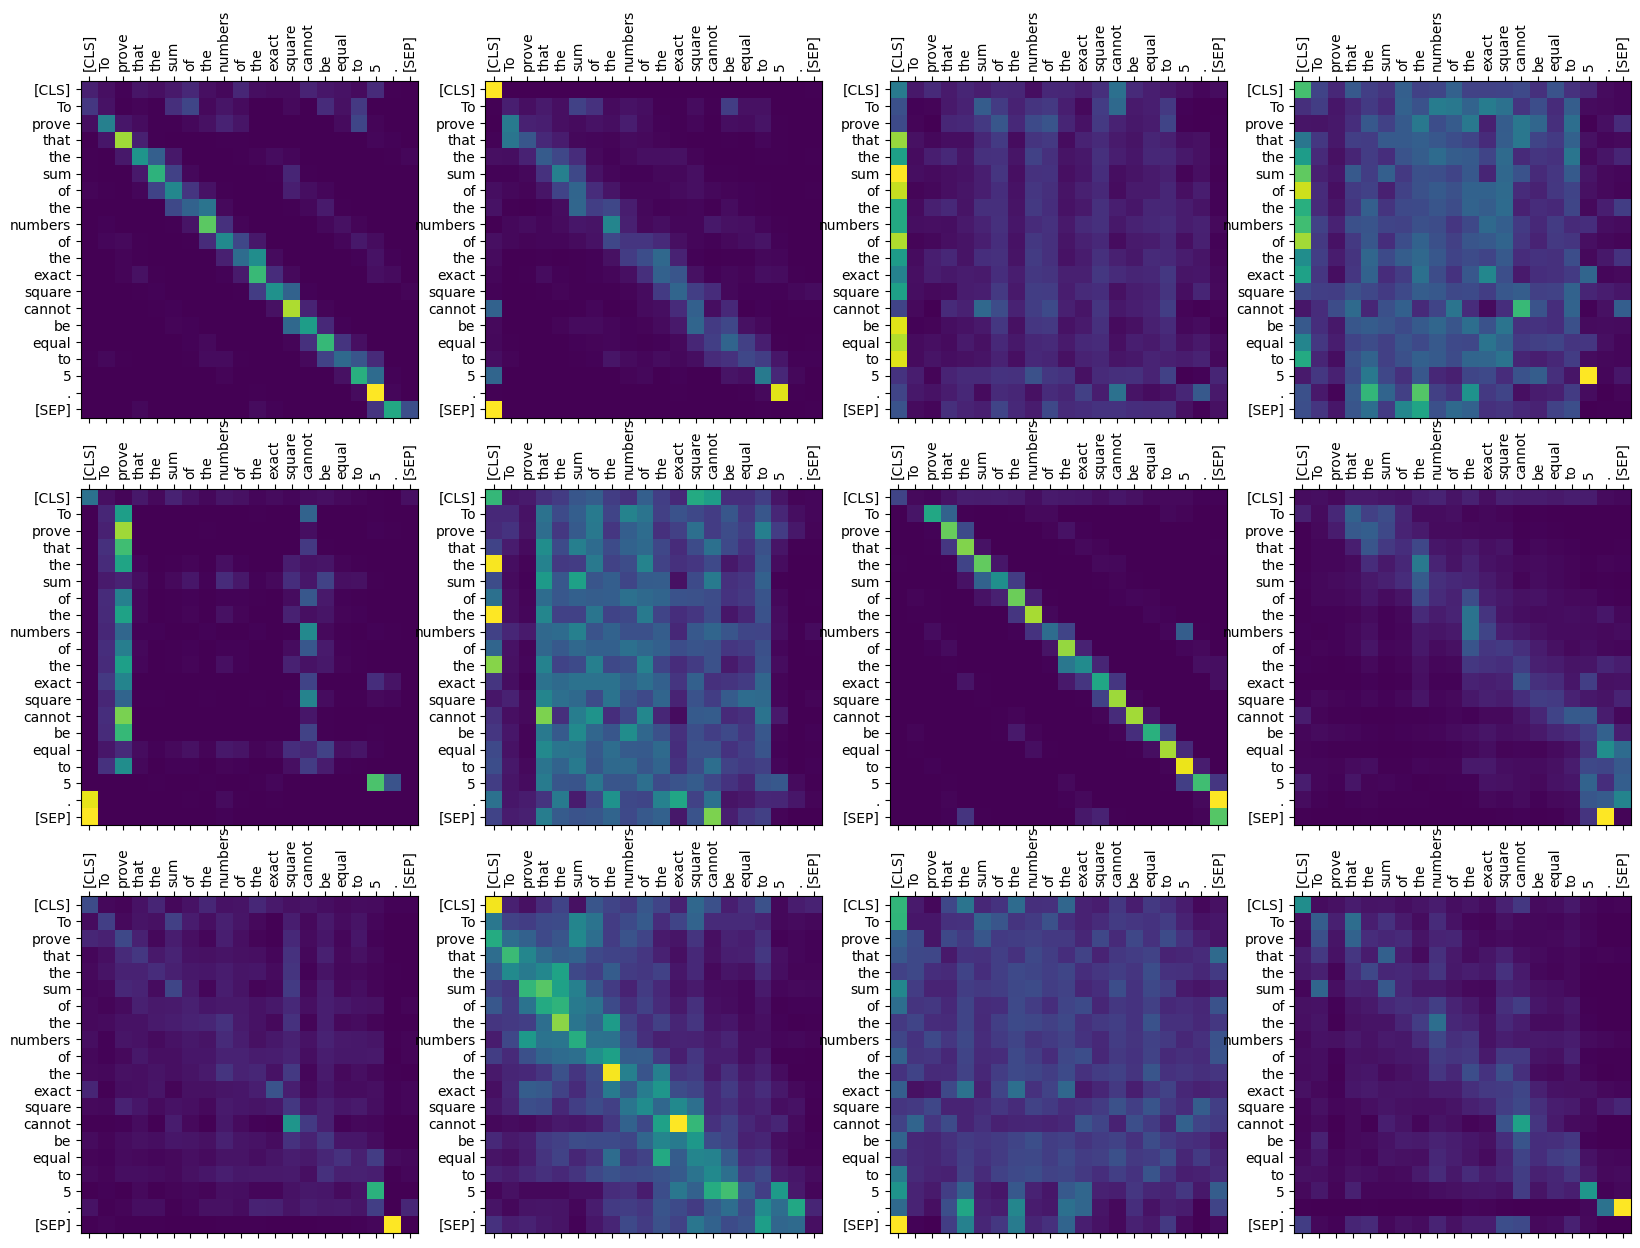

Название модели: cointegrated/rubert-tiny2


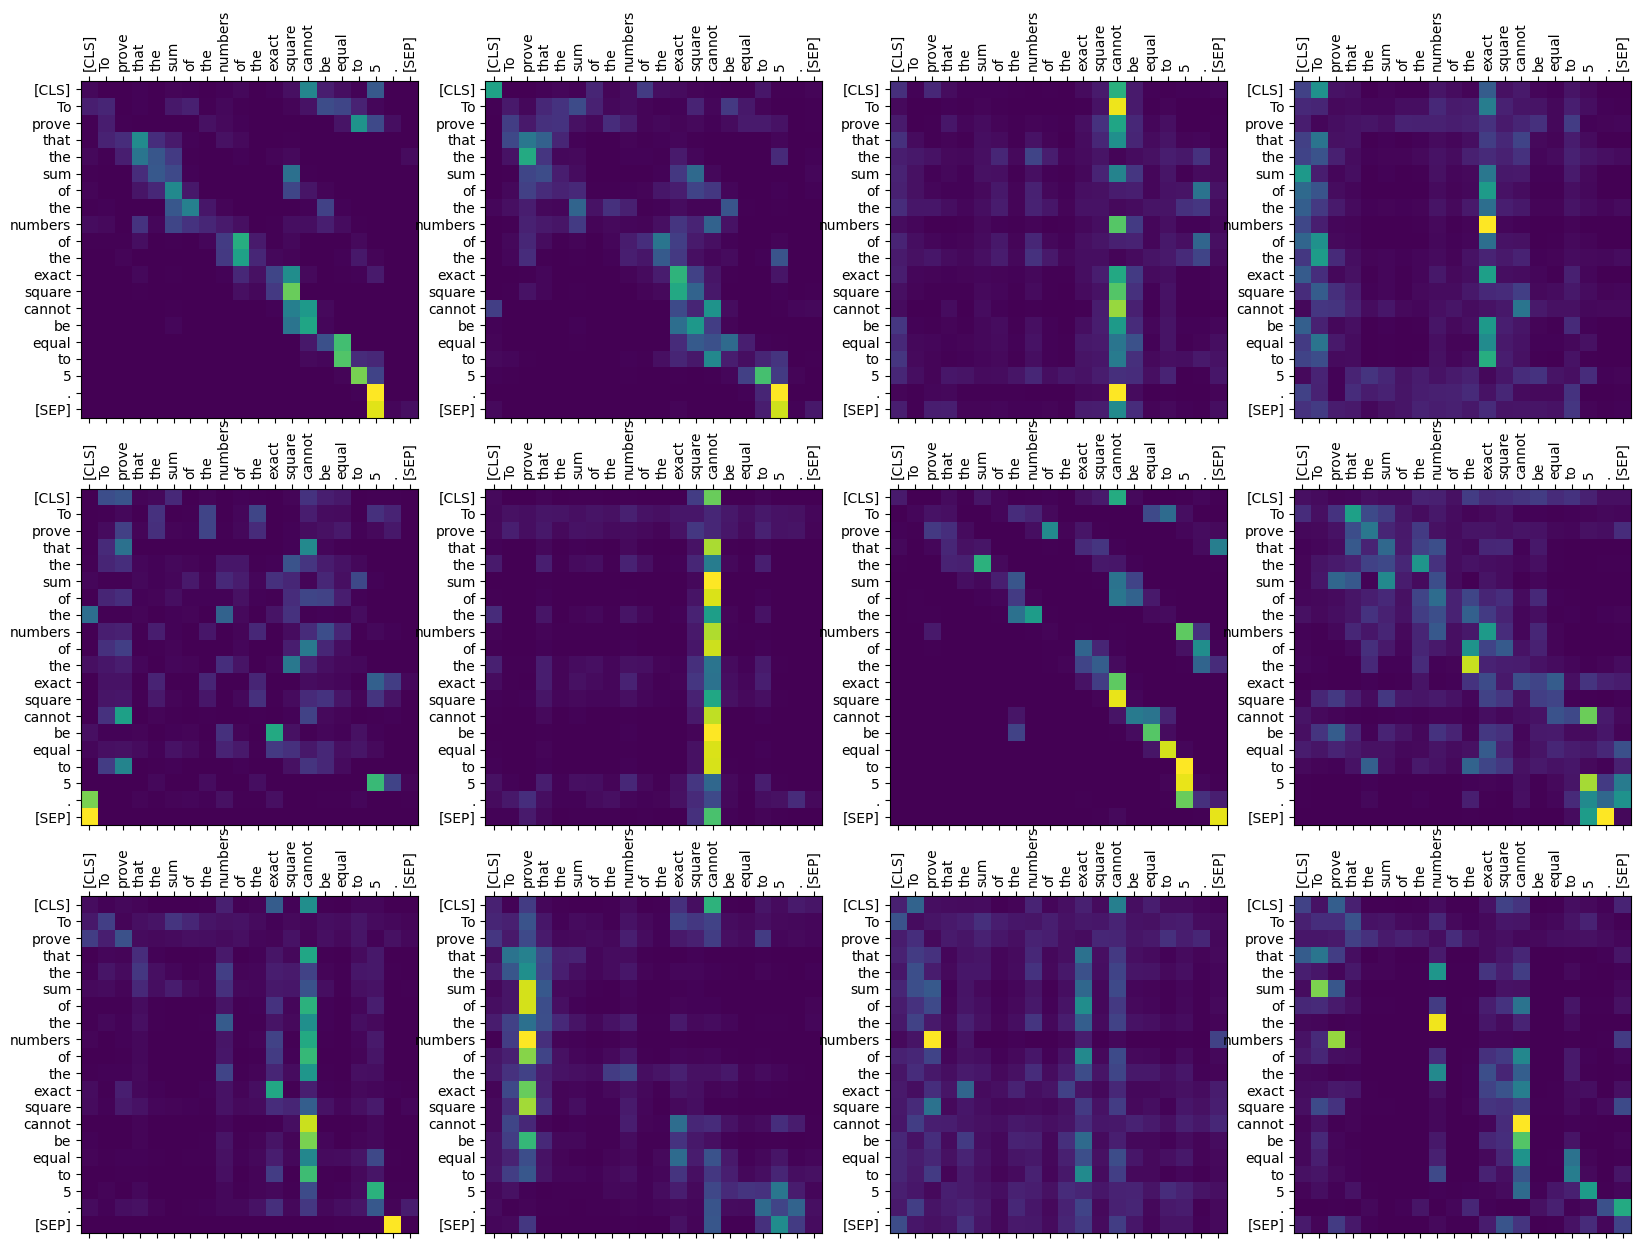

Название модели: tbs17/MathBert


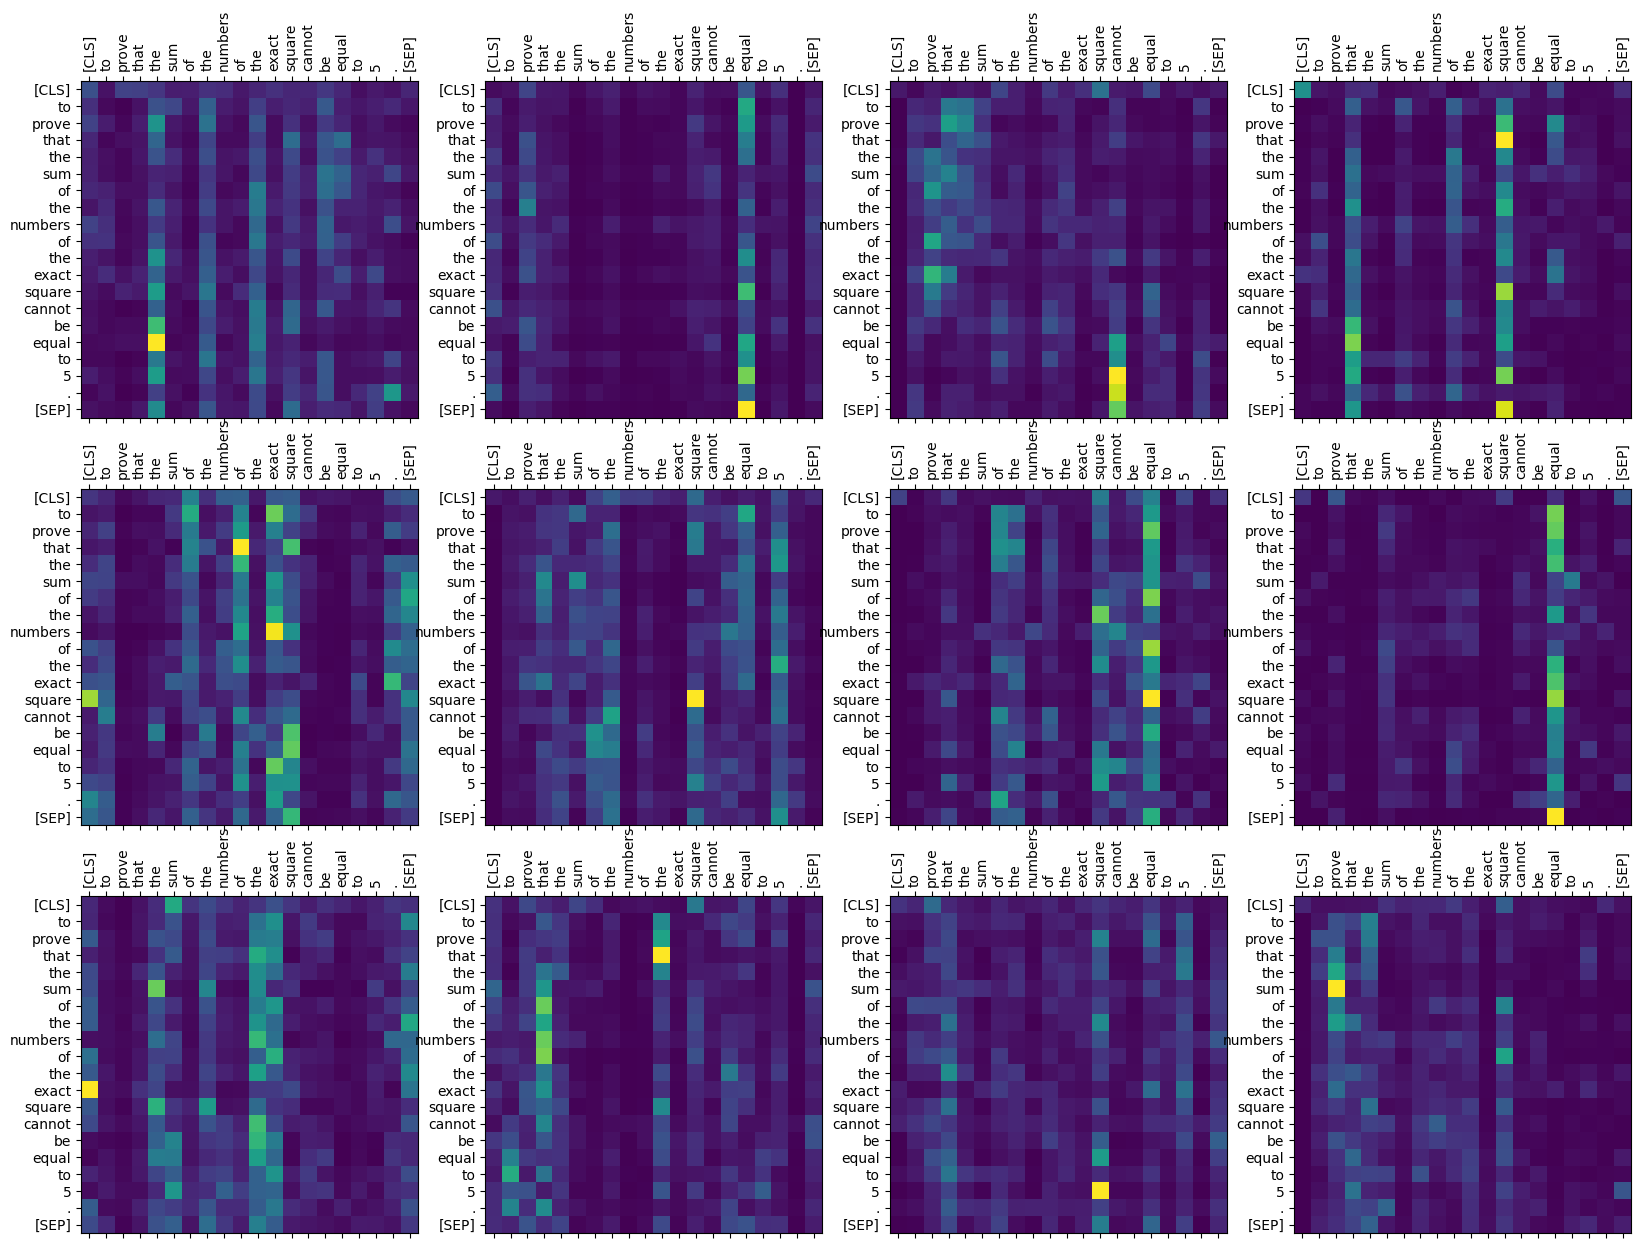

Название модели: tbs17/MathBert


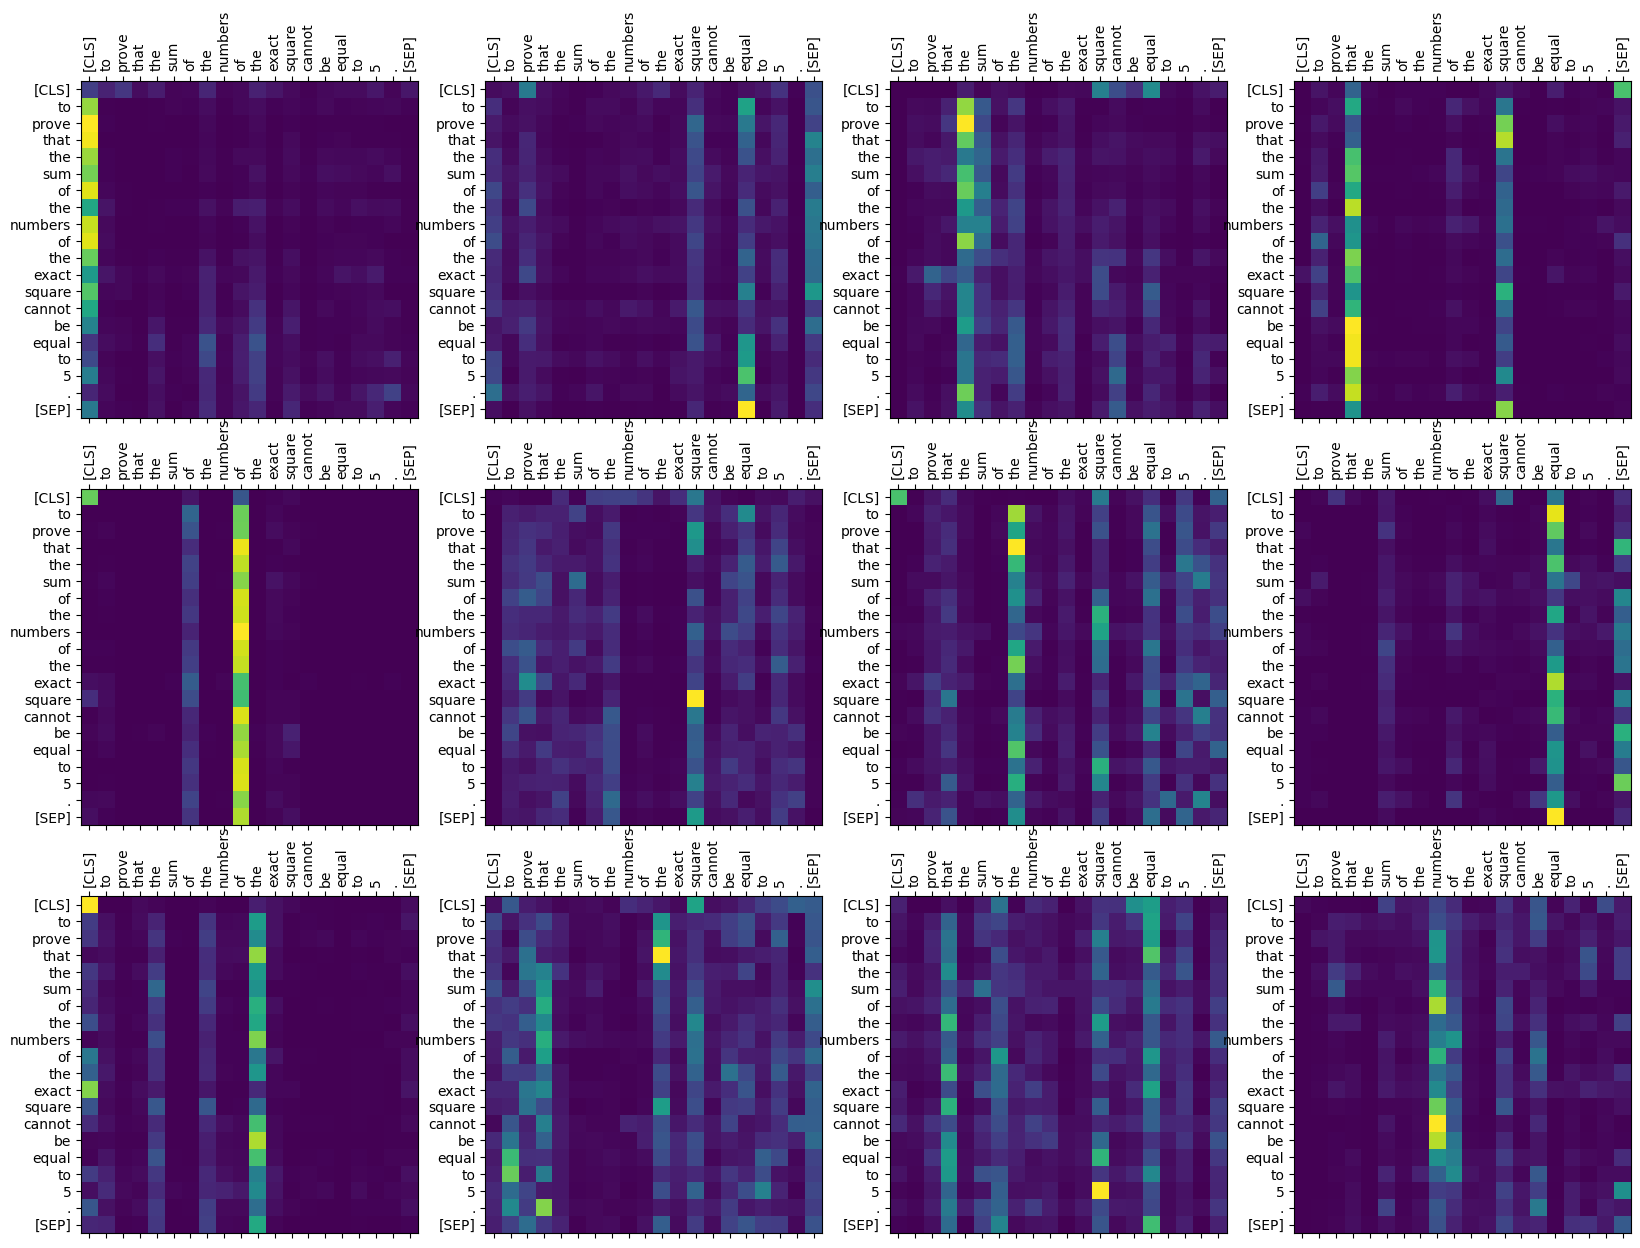

In [24]:
text = dataset[0]['text']
print("Текст:", text)
for model_stuff in models['finetuned']:
    draw_first_layer_attention_maps(text,  model_stuff)